In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
import time
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [16]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [17]:
# Read in data from small csv to a dataframe
df1=pd.read_csv('weather_large.csv', sep=',')

# Reformat data in date/time column 
df1['Formatted Date'] =  pd.to_datetime(df1['Formatted Date'])

# Create a new column for year / month / hour
df1['Year'] = pd.DatetimeIndex(df1['Formatted Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Formatted Date']).month
df1['Hour'] = pd.DatetimeIndex(df1['Formatted Date']).hour

# Encode month and hour for cyclical nature
df1 = encode(df1, 'Month', 13)
df1 = encode(df1, 'Hour', 23)
df1 = encode(df1, 'Wind Bearing (degrees)', 359)

# Remove original date/time column
df1=df1.drop(['Formatted Date'],axis=1)

# Convert columns to factors
df1['Summary'] = df1['Summary'].astype('category')
df1['Precip Type'] = df1['Precip Type'].astype('category')
df1['Daily Summary'] = df1['Daily Summary'].astype('category')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['Heavy_Cloud'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 1,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 1,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 1,0)))

# Convert to boolean and print count
df1['Heavy_Cloud']=df1['Heavy_Cloud'].astype('bool')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['New_Summary'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 0,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 0,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 0,
                    pd.np.where(df1.Summary.str.contains("Rain"), 0,
                    pd.np.where(df1.Summary.str.contains("Drizzle"), 0,            
                    pd.np.where(df1.Summary.str.contains("Partly Cloudy"), 1,2))))))

# Convert to boolean and print count
df1['New_Summary']=df1['New_Summary'].astype('category')

In [18]:
### Create and scale new value for X based on strongest variables
X=pd.DataFrame(scale(df1[['Temperature (C)','Apparent Temperature (C)','Humidity','Month_sin','Month_cos',]]))
# X=pd.DataFrame(X,columns=['Temperature (C)','Apparent Temperature (C)','Humidity','Month_sin','Month_cos'])
y=df1["New_Summary"]

In [19]:
### Create training, validation and test data
# Create Training&Validation / Test set - split of 70/20/10
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X,y,test_size=0.1) 
X_valid, X_train, y_valid, y_train = train_test_split(X_intermediate, y_intermediate,
                                                      test_size=0.78)
# delete intermediate variables
X_intermediate, y_intermediate

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))

train: 0.7% | validation: 0.2% | test 0.1%


In [20]:
# Create KNN Model
knn = KNeighborsClassifier(n_neighbors=10)

# Train the model using the training sets
start_time = time.clock()
knn.fit(X_train, y_train)
predictions = knn.predict(X_valid)
print (time.clock() - start_time, "seconds")


0.26775099999999963 seconds


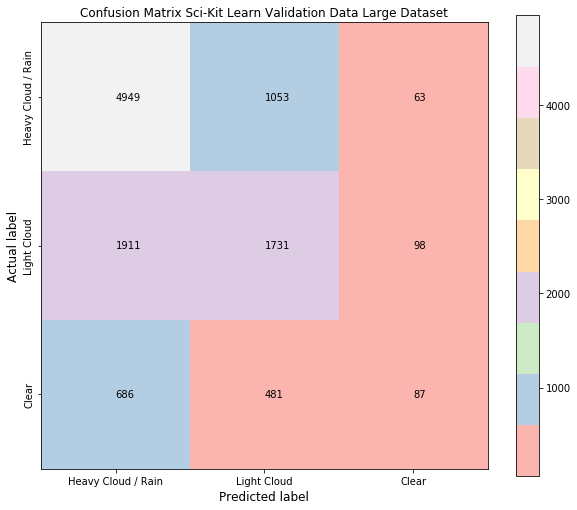

In [21]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_valid, predictions)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Sci-Kit Learn Validation Data Large Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=0)
plt.yticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=90,verticalalignment='center')
# plt.axis["left"].major_ticklabels.set_ha("center")
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm[x][y]), xy=(y, x), 
  horizontalalignment='centre',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('KNN_Validation_Confusion_Matrix_Large_SK.png',pdi=600)

In [22]:
Score=metrics.accuracy_score(y_valid, predictions)
ERR=1-Score

Recall_Heavy_Cloud=(cm[0,0])/(np.sum(cm,axis=1)[0])
FNR_Heavy_Cloud=1-Recall_Heavy_Cloud
FPR_Heavy_Cloud=((cm[1,0])+cm[2,0])/((np.sum(cm,axis=1)[1])+(np.sum(cm,axis=1)[2]))
Specificity_Heavy_Cloud=1-FPR_Heavy_Cloud

Recall_Light_Cloud=(cm[1,1])/(np.sum(cm,axis=1)[1])
FNR_Light_Cloud=1-Recall_Light_Cloud
FPR_Light_Cloud=((cm[0,1])+cm[2,1])/((np.sum(cm,axis=1)[0])+(np.sum(cm,axis=1)[2]))
Specificity_Light_Cloud=1-FPR_Light_Cloud

Recall_Clear=(cm[2,2])/(np.sum(cm,axis=1)[2])
FNR_Clear=1-Recall_Clear
FPR_Clear=((cm[0,2])+cm[1,2])/((np.sum(cm,axis=1)[0])+(np.sum(cm,axis=1)[1]))
Specificity_Clear=1-FPR_Clear


print('Score of validation model: ',Score)
print('Error rate of validation model: ',ERR)

print('\nRecall / TPR (Clear) of validation model: ',Recall_Clear)
print('FNR (Clear) of validation model: ',FNR_Clear)
print('Specificity / TNR (Clear) of validation model: ',Specificity_Clear)
print('FPR (Clear) of validation model: ',FPR_Clear)

print('\nRecall / TPR (Light Cloud) of validation model: ',Recall_Light_Cloud)
print('FNR (Light Cloud) of validation model: ',FNR_Light_Cloud)
print('Specificity / TNR (Light Cloud) of validation model: ',Specificity_Light_Cloud)
print('FPR (Light Cloud) of validation model: ',FPR_Light_Cloud)

print('\nRecall / TPR (Heavy Cloud / Rain) of validation model: ',Recall_Heavy_Cloud)
print('FNR (Heavy Cloud / Rain) of validation model: ',FNR_Heavy_Cloud)
print('Specificity / TNR (Heavy Cloud / Rain) of validation model: ',Specificity_Heavy_Cloud)
print('FPR (Heavy Cloud / Rain) of validation model: ',FPR_Heavy_Cloud)


Score of validation model:  0.6118998101094132
Error rate of validation model:  0.3881001898905868

Recall / TPR (Clear) of validation model:  0.06937799043062201
FNR (Clear) of validation model:  0.930622009569378
Specificity / TNR (Clear) of validation model:  0.9835798062213157
FPR (Clear) of validation model:  0.016420193778684346

Recall / TPR (Light Cloud) of validation model:  0.4628342245989305
FNR (Light Cloud) of validation model:  0.5371657754010695
Specificity / TNR (Light Cloud) of validation model:  0.7904085257548845
FPR (Light Cloud) of validation model:  0.20959147424511546

Recall / TPR (Heavy Cloud / Rain) of validation model:  0.8159934047815334
FNR (Heavy Cloud / Rain) of validation model:  0.18400659521846663
Specificity / TNR (Heavy Cloud / Rain) of validation model:  0.4799759711653985
FPR (Heavy Cloud / Rain) of validation model:  0.5200240288346015


In [23]:
y_valid_bin = label_binarize(y_valid, classes=[0,1,2])
predictions_bin=label_binarize(predictions,classes=[0,1,2])

n_classes = y_valid_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_bin.ravel(), predictions_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


print("AUC of Clear validation model",roc_auc[2])
print("AUC of Light Cloud validation model",roc_auc[1])
print("AUC of Heavy Cloud / Rain validation model",roc_auc[0])
print("AUC of micro average validation model",roc_auc["micro"])
print("AUC of macro average validation model",roc_auc["macro"])


AUC of Clear validation model 0.5264788983259688
AUC of Light Cloud validation model 0.6266213751769075
AUC of Heavy Cloud / Rain validation model 0.6479846879734659
AUC of micro average validation model 0.7089248575820598
AUC of macro average validation model 0.6003616538254473


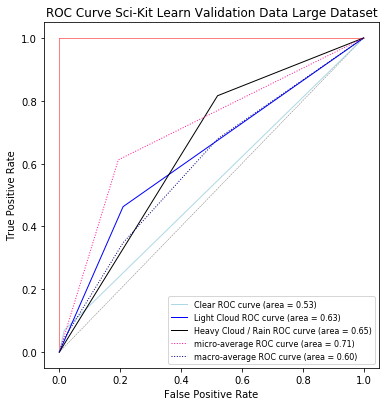

In [24]:
# Plot all ROC curves
fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red',linewidth=0.5)
ax1.plot(x2, y2, 'red',linewidth=0.5)
ax1.plot(x2, y1, 'grey',linestyle='--',linewidth=0.5)

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Sci-Kit Learn Validation Data Large Dataset')

ax1.plot(fpr[2],tpr[2],
         label='Clear ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[2]),
         color='lightblue',linewidth=1)

ax1.plot(fpr[1],tpr[1],
         label='Light Cloud ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[1]),
         color='blue',linewidth=1)

ax1.plot(fpr[0],tpr[0],
         label='Heavy Cloud / Rain ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[0]),
         color='black',linewidth=1)


ax1.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=1)

ax1.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=1)

ax1.legend(loc="lower right",fontsize=8)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('KNN_Validation_ROC_Large_SK.png',pdi=600)

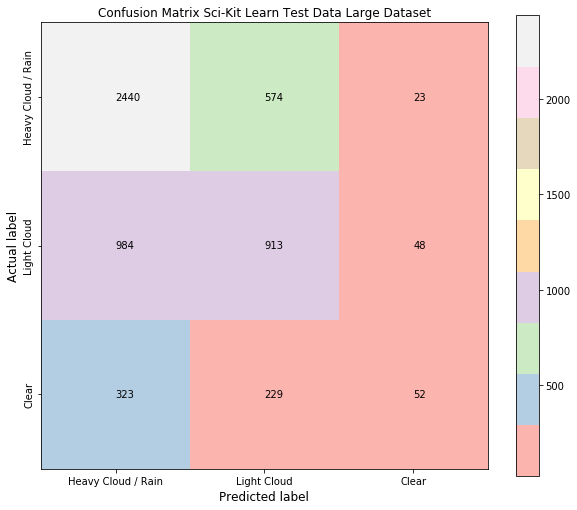

In [25]:
predictions_test = knn.predict(X_test)

# Confusion Matrix
cm2 = metrics.confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(10,8))
plt.imshow(cm2, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Sci-Kit Learn Test Data Large Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=0)
plt.yticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=90,verticalalignment='center')
# plt.axis["left"].major_ticklabels.set_ha("center")
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm2.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm2[x][y]), xy=(y, x), 
  horizontalalignment='centre',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('KNN_Test_Confusion_Matrix_Large_SK.png',pdi=600)

In [26]:
Score=metrics.accuracy_score(y_test, predictions_test)
ERR=1-Score

Recall_Heavy_Cloud=(cm2[0,0])/(np.sum(cm2,axis=1)[0])
FNR_Heavy_Cloud=1-Recall_Heavy_Cloud
FPR_Heavy_Cloud=((cm2[1,0])+cm2[2,0])/((np.sum(cm2,axis=1)[1])+(np.sum(cm2,axis=1)[2]))
Specificity_Heavy_Cloud=1-FPR_Heavy_Cloud

Recall_Light_Cloud=(cm2[1,1])/(np.sum(cm2,axis=1)[1])
FNR_Light_Cloud=1-Recall_Light_Cloud
FPR_Light_Cloud=((cm2[0,1])+cm2[2,1])/((np.sum(cm2,axis=1)[0])+(np.sum(cm2,axis=1)[2]))
Specificity_Light_Cloud=1-FPR_Light_Cloud

Recall_Clear=(cm2[2,2])/(np.sum(cm2,axis=1)[2])
FNR_Clear=1-Recall_Clear
FPR_Clear=((cm2[0,2])+cm2[1,2])/((np.sum(cm2,axis=1)[0])+(np.sum(cm2,axis=1)[1]))
Specificity_Clear=1-FPR_Clear


print('Score of test model: ',Score)
print('Error rate of test model: ',ERR)

print('\nRecall / TPR (Clear) of test model: ',Recall_Clear)
print('FNR (Clear) of test model: ',FNR_Clear)
print('Specificity / TNR (Clear) of test model: ',Specificity_Clear)
print('FPR (Clear) of test model: ',FPR_Clear)

print('\nRecall / TPR (Light Cloud) of test model: ',Recall_Light_Cloud)
print('FNR (Light Cloud) of test model: ',FNR_Light_Cloud)
print('Specificity / TNR (Light Cloud) of test model: ',Specificity_Light_Cloud)
print('FPR (Light Cloud) of test model: ',FPR_Light_Cloud)

print('\nRecall / TPR (Heavy Cloud / Rain) of test model: ',Recall_Heavy_Cloud)
print('FNR (Heavy Cloud / Rain) of test model: ',FNR_Heavy_Cloud)
print('Specificity / TNR (Heavy Cloud / Rain) of test model: ',Specificity_Heavy_Cloud)
print('FPR (Heavy Cloud / Rain) of test model: ',FPR_Heavy_Cloud)

Score of test model:  0.6095596133190118
Error rate of test model:  0.39044038668098824

Recall / TPR (Clear) of test model:  0.08609271523178808
FNR (Clear) of test model:  0.9139072847682119
Specificity / TNR (Clear) of test model:  0.9857486953030912
FPR (Clear) of test model:  0.014251304696908872

Recall / TPR (Light Cloud) of test model:  0.46940874035989716
FNR (Light Cloud) of test model:  0.5305912596401028
Specificity / TNR (Light Cloud) of test model:  0.7794561933534743
FPR (Light Cloud) of test model:  0.22054380664652568

Recall / TPR (Heavy Cloud / Rain) of test model:  0.8034244320052684
FNR (Heavy Cloud / Rain) of test model:  0.19657556799473164
Specificity / TNR (Heavy Cloud / Rain) of test model:  0.4872499019223224
FPR (Heavy Cloud / Rain) of test model:  0.5127500980776776


In [27]:
y_test_bin = label_binarize(y_test, classes=[0,1,2])
predictions_test_bin=label_binarize(predictions_test,classes=[0,1,2])

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_test_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predictions_test_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


print("AUC of Clear test model",roc_auc[2])
print("AUC of Light Cloud test model",roc_auc[1])
print("AUC of Heavy Cloud / Rain test model",roc_auc[0])
print("AUC of micro average test model",roc_auc["micro"])
print("AUC of macro average test model",roc_auc["macro"])

AUC of Clear test model 0.5359207052674396
AUC of Light Cloud test model 0.6244324668566857
AUC of Heavy Cloud / Rain test model 0.6453371669637954
AUC of micro average test model 0.7071697099892589
AUC of macro average test model 0.6018967796959737


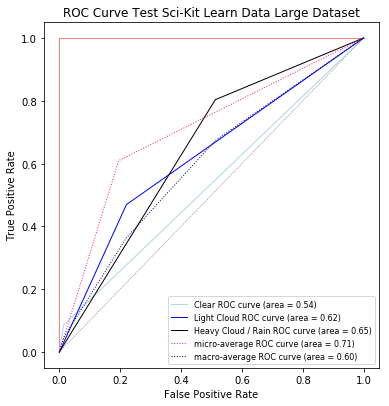

In [28]:
# Plot all ROC curves
fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red',linewidth=0.5)
ax1.plot(x2, y2, 'red',linewidth=0.5)
ax1.plot(x2, y1, 'grey',linestyle='--',linewidth=0.5)

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Test Sci-Kit Learn Data Large Dataset')

ax1.plot(fpr[2],tpr[2],
         label='Clear ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[2]),
         color='lightblue',linewidth=1)

ax1.plot(fpr[1],tpr[1],
         label='Light Cloud ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[1]),
         color='blue',linewidth=1)

ax1.plot(fpr[0],tpr[0],
         label='Heavy Cloud / Rain ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[0]),
         color='black',linewidth=1)

ax1.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=1)

ax1.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=1)

ax1.legend(loc="lower right",fontsize=8)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('KNN_Test_ROC_Large_SK.png',pdi=600)